In [1]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fmdtools.faultsim as fs
import fmdtools.resultdisp as rd
import quadpy
from IPython.display import HTML

In [2]:
from fmdtools.modeldef import FxnBlock
from fmdtools.modeldef import Flow
from fmdtools.modeldef import Model
from fmdtools.modeldef import m2to1
from fmdtools.modeldef import Component
from fmdtools.modeldef import SampleApproach

### Initial Model


In our initial model, all we have is the flows, functions, and connections between them. These are set up in a model class as shown:

In [3]:
class Drone(Model):
    def __init__(self, params={}):
        super().__init__()
        self.params=params
        #add flows to the model
        self.add_flow('Force_ST', {})
        self.add_flow('Force_Lin', {})
        self.add_flow('Force_GR' , {})
        self.add_flow('Force_LG', {})
        self.add_flow('EE_1', {})
        self.add_flow('EEmot', {})
        self.add_flow('EEctl', {})
        self.add_flow('Ctl1', {})
        self.add_flow('DOFs', {})
        self.add_flow('Env1', {})
        # custom flows
        self.add_flow('Dir1', {})
        #add functions to the model
        flows=['EEctl', 'Force_ST']
        self.add_fxn('StoreEE',['EE_1', 'Force_ST'])
        self.add_fxn('DistEE', ['EE_1','EEmot','EEctl', 'Force_ST'])
        self.add_fxn('AffectDOF',['EEmot','Ctl1','DOFs','Force_Lin'])
        self.add_fxn('CtlDOF', ['EEctl', 'Dir1', 'Ctl1', 'DOFs', 'Force_ST'])
        self.add_fxn('Planpath', ['EEctl', 'Env1','Dir1', 'Force_ST'])
        self.add_fxn('Trajectory', ['Env1','DOFs','Dir1', 'Force_GR'] )
        self.add_fxn('EngageLand',['Force_GR', 'Force_LG'])
        self.add_fxn('HoldPayload',['Force_LG', 'Force_Lin', 'Force_ST'])
        self.add_fxn('ViewEnv', ['Env1'])
        
        self.construct_graph()

### Setting Node Positions

As shown below, it can be difficult to make sense of a model structure using the default shell graph layout. We might instead want to see something that more closely approximates a flow chart of the system.

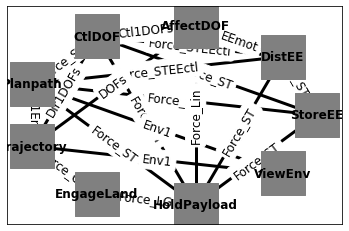

In [4]:
mdl = Drone()
rd.graph.show(mdl.graph)

To set node positions, we can use ``rd.graph.set_pos()``, which lets one drag the nodes to their desired locations. If a model is sent to ``set_pos``, it will set those locations in the model going forward, though it is good practice to save node locations when one is done in the script or the model class file (they can be used as inputs to ``construct_graph()``.

In [5]:
%matplotlib qt5
pos = rd.graph.set_pos(mdl)
pos

{'StoreEE': [1.0, 6.622738357719982e-09],
 'DistEE': [0.7660444974899292, 0.6427875757217407],
 'AffectDOF': [0.17364825308322906, 0.9848077297210693],
 'CtlDOF': [-0.5, 0.8660253882408142],
 'Planpath': [-0.9396925568580627, 0.3420202136039734],
 'Trajectory': [-0.9396925568580627, -0.3420201539993286],
 'EngageLand': [-0.49999988079071045, -0.866025447845459],
 'HoldPayload': [0.1736481785774231, -0.9848077297210693],
 'ViewEnv': [0.7660443782806396, -0.642787754535675]}

In [7]:
graph_pos = {'StoreEE': [-1.0787279392101061, -0.06903523859088145],
 'DistEE': [-0.361531174332526, -0.0935883732235363],
 'AffectDOF': [0.36541282312106205, -0.09674444529230719],
 'CtlDOF': [0.4664934329906758, 0.5822138245848214],
 'Planpath': [-0.7095750728126631, 0.8482786785038505],
 'Trajectory': [1.1006824683444765, -0.10423208715241583],
 'EngageLand': [0.8423521094741182, -0.8813666134484857],
 'HoldPayload': [-0.5857395187723944, -0.86974898769837],
 'ViewEnv': [1.1035500215472247, 0.9373523025760659]}

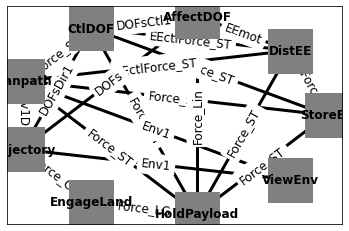

In [8]:
%matplotlib inline
rd.graph.show(mdl)

We can use the same process to arrange the bipartite graph:

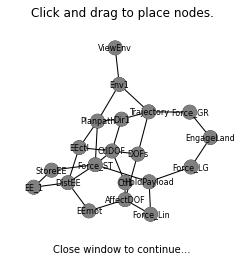

Cannot place nodes in inline version of plot. Use '%matplotlib qt' to open in external window


{'StoreEE': [-0.6590746177534565, -0.17013217923654622],
 'DistEE': [-0.5027523791003043, -0.2900482046866976],
 'AffectDOF': [0.04388006211212828, -0.4523376711256241],
 'CtlDOF': [-0.08175966925092142, 0.013270983425692676],
 'Planpath': [-0.2197002769283844, 0.2993050072365193],
 'Trajectory': [0.2710210394637667, 0.3879699048051331],
 'EngageLand': [0.8601179949843458, 0.14191554991160646],
 'HoldPayload': [0.2740573429718468, -0.28138364035079605],
 'ViewEnv': [-0.05048272901601274, 1.0],
 'Force_ST': [-0.2417100544731615, -0.11765796893673709],
 'Force_Lin': [0.2882343112597164, -0.592251394106947],
 'Force_GR': [0.6621841362623493, 0.3852718352934739],
 'Force_LG': [0.674703472038131, -0.13958356299563654],
 'EE_1': [-0.8296810433208722, -0.3330821424514873],
 'EEmot': [-0.30194466450804125, -0.5599323491211151],
 'EEctl': [-0.39481567252683375, 0.04630959030202359],
 'Ctl1': [0.04410710183522733, -0.2897563734085863],
 'DOFs': [0.1655503669673828, -0.016251111880379303],
 'Env1

In [6]:
%matplotlib qt5
pos = rd.graph.set_pos(mdl, gtype='bipartite')

As shown, in a large model, the Bipartite graph is often easier to arrange to get a good layout. Since the model will be redefined several times going forward, we will use these positions to keep a consistent layout:

In [7]:
bipartite_pos = {'StoreEE': [-1.067135163123663, 0.32466987344741055],
 'DistEE': [-0.617149602161968, 0.3165981670924663],
 'AffectDOF': [0.11827439153655106, 0.10792528450121897],
 'CtlDOF': [-0.2636856982162134, 0.42422600969836144],
 'Planpath': [-0.9347151173753852, 0.6943421719257798],
 'Trajectory': [0.6180477286739998, 0.32930706399226856],
 'EngageLand': [0.0015917696269229786, -0.2399760932810826],
 'HoldPayload': [-0.8833099612826893, -0.247201580673997],
 'ViewEnv': [0.5725955705698363, 0.6901513410348765],
 'Force_ST': [-0.8925771348524384, -0.025638904424547027],
 'Force_Lin': [-0.5530952425102891, -0.10380834289626095],
 'Force_GR': [0.568921162299461, -0.22991830334765573],
 'Force_LG': [-0.37244114591548894, -0.2355298479531287],
 'EE_1': [-0.809433489993954, 0.319191761486317],
 'EEmot': [-0.33469985340998853, 0.1307636433702345],
 'EEctl': [-0.48751243650229525, 0.4852032717825657],
 'Ctl1': [-0.06913038312848868, 0.2445174568603189],
 'DOFs': [0.2606664304933561, 0.3243482171363975],
 'Env1': [0.06157634305459603, 0.7099922980251693],
 'Dir1': [-0.13617863906968142, 0.6037252153639261]}

graph_pos = {'StoreEE': [-1.0787279392101061, -0.06903523859088145],
 'DistEE': [-0.361531174332526, -0.0935883732235363],
 'AffectDOF': [0.36541282312106205, -0.09674444529230719],
 'CtlDOF': [0.4664934329906758, 0.5822138245848214],
 'Planpath': [-0.7095750728126631, 0.8482786785038505],
 'Trajectory': [1.1006824683444765, -0.10423208715241583],
 'EngageLand': [0.8423521094741182, -0.8813666134484857],
 'HoldPayload': [-0.5857395187723944, -0.86974898769837],
 'ViewEnv': [1.1035500215472247, 0.9373523025760659]}

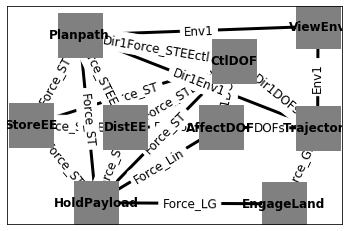

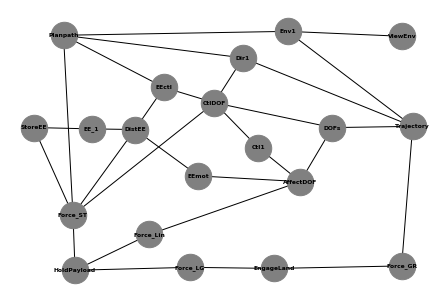

In [8]:
%matplotlib inline
rd.graph.show(mdl, pos=graph_pos)
rd.graph.show(mdl, gtype='bipartite', pos=bipartite_pos)

### Network Model
- compute network metrics
- visualize network vulnerabilities

We can calculate network metrics using calc_aspl, calc_modularity, and calc_robustness_coefficient in the `networks` module.

In [9]:
aspl = fs.networks.calc_aspl(mdl,gtype='normal')
q = fs.networks.calc_modularity(mdl,gtype='normal')
rc = fs.networks.calc_robustness_coefficient(mdl,gtype='normal')

print("ASPL: %.2f" % round(aspl, 2))
print("Modularity: %.2f" % round(q,2))
print("Robustness Coefficient: %.2f" % round(rc,2))

ASPL: 1.44
Modularity: 0.12
Robustness Coefficient: 95.70


Next, we visualize network vulnerabilities using find_bridging_nodes and find_high_degree_nodes.

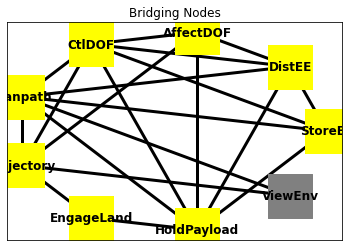

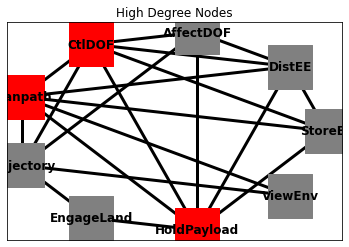

In [10]:
[bridging_nodes,fig_bridging_nodes,ax_bridging_nodes] = fs.networks.find_bridging_nodes(mdl,plot='on',gtype='normal')
[high_degree_nodes,fig_high_degree_nodes,ax_high_degree_nodes] = fs.networks.find_high_degree_nodes(mdl,plot='on',gtype='normal')

High degree nodes (along with their degrees) and bridging nodes are also obtainable as lists.

In [11]:
print('Bridging Nodes:',bridging_nodes)
print('High Degree Nodes:',high_degree_nodes)

Bridging Nodes: ['AffectDOF', 'CtlDOF', 'DistEE', 'EngageLand', 'HoldPayload', 'Planpath', 'StoreEE', 'Trajectory']
High Degree Nodes: [('CtlDOF', 6), ('Planpath', 6), ('HoldPayload', 6)]


Finally, we can plot the degree distribution of the network using degree_dist.

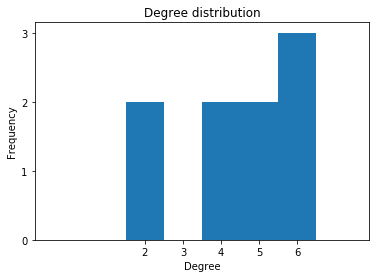

In [12]:
fs.networks.degree_dist(mdl,gtype='normal')

The above analysis includes only function nodes. It is also possible to treat the bipartite graph (containing both functions and flows) as a unipartite-like graph and perform similar analysis on both function and flow nodes.

In [13]:
aspl = fs.networks.calc_aspl(mdl,gtype='bipartite')
q = fs.networks.calc_modularity(mdl,gtype='bipartite')
rc = fs.networks.calc_robustness_coefficient(mdl,gtype='bipartite')

print("ASPL, functions and flows: %.2f" % round(aspl, 2))
print("Modularity, functions and flows: %.2f" % round(q,2))
print("Robustness Coefficient, functions and flows: %.2f" % round(rc,2))

ASPL, functions and flows: 2.77
Modularity, functions and flows: 0.35
Robustness Coefficient, functions and flows: 81.42


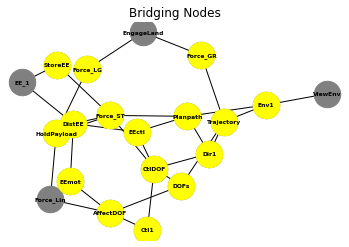

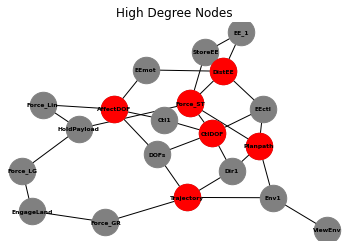

In [14]:
[bridging_nodes,fig_bridging_nodes,ax_bridging_nodes] = fs.networks.find_bridging_nodes(mdl,plot='on',gtype='bipartite')
[high_degree_nodes,fig_high_degree_nodes,ax_high_degree_nodes] = fs.networks.find_high_degree_nodes(mdl,plot='on',gtype='bipartite')

In [15]:
print('Bridging Nodes:',bridging_nodes)
print('High Degree Nodes:',high_degree_nodes)

Bridging Nodes: ['AffectDOF', 'Ctl1', 'CtlDOF', 'DOFs', 'Dir1', 'DistEE', 'EEctl', 'EEmot', 'Env1', 'Force_GR', 'Force_LG', 'Force_ST', 'HoldPayload', 'Planpath', 'StoreEE', 'Trajectory']
High Degree Nodes: [('CtlDOF', 5), ('Force_ST', 5), ('DistEE', 4), ('AffectDOF', 4), ('Planpath', 4), ('Trajectory', 4)]


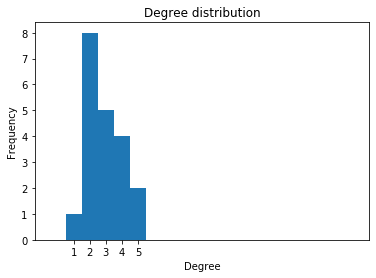

In [16]:
fs.networks.degree_dist(mdl,gtype='bipartite')

Other than the bipartite graph, there are also options for the parameter network and component network.

### Static Model

In this demonstration, we will use a static representation of the system model to displaygraph views of fault scenarios and produce a static FMEA

The static model is located in `drone_mdl_static.py`.

In [17]:
from drone_mdl_static import Drone as Drone_Static

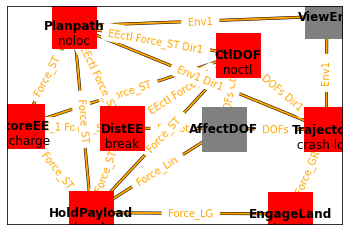

In [21]:
endresults, resgraph, mdlhist = fs.propagate.one_fault(static_mdl,'StoreEE', 'nocharge')
rd.graph.show(resgraph, pos = graph_pos, scale=2)

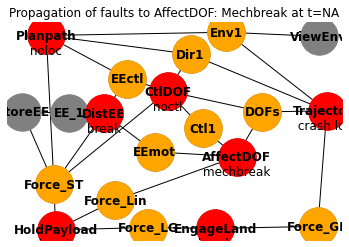

In [22]:
endresults, resgraph, mdlhist = fs.propagate.one_fault(static_mdl,'AffectDOF', 'mechbreak', gtype='bipartite')
fig, ax = rd.graph.show(resgraph, pos = bipartite_pos, faultscen='AffectDOF: Mechbreak', time='NA', scale=2, gtype='bipartite', retfig=True)
fig.savefig('static_propagation.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0)

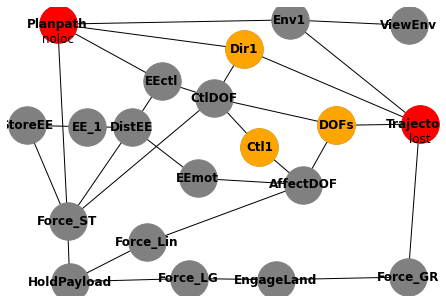

In [23]:
In design, it often helps to quantify the relative impact of fault scenarios. Here we produce a scenario-based FMEA to show which scenarios are most important in the model:

In [18]:
static_mdl = Drone_Static(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endclasses, mdlhists = fs.propagate.single_faults(static_mdl)

In [19]:
reshists, diffs, summaries = rd.process.hists(mdlhists)
static_fmea = rd.tabulate.fullfmea(endclasses, summaries)
static_fmea.sort_values('expected cost', ascending=False)

,degraded functions,degraded flows,rate,cost,expected cost
"StoreEE nocharge, t=1","[StoreEE, DistEE, CtlDOF, Planpath, Trajectory...","[Force_ST, Force_Lin, Force_GR, Force_LG, EE_1...",1e-05,183300,183300
"Planpath degloc, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",8e-06,193000,154400
"DistEE short, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",3e-06,186000,55800
"AffectDOF ctlbreak, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",2e-06,184000,36800
"AffectDOF ctlup, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",2e-06,183500,36700
"DistEE break, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",2e-06,183000,36600
"CtlDOF noctl, t=1","[DistEE, CtlDOF, Planpath, Trajectory, EngageL...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",2e-06,183000,36600
"AffectDOF short, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EE_1...",1e-06,186200,18620
"AffectDOF mechbreak, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",1e-06,183500,18350
"AffectDOF openc, t=1","[DistEE, AffectDOF, CtlDOF, Planpath, Trajecto...","[Force_ST, Force_Lin, Force_GR, Force_LG, EEmo...",1e-06,183200,18320


We can in turn visualize these faults on the graph representation of the system. Here we will focus on the break of one of the rotors in the AffectDOF function, the effects of which are shown below:

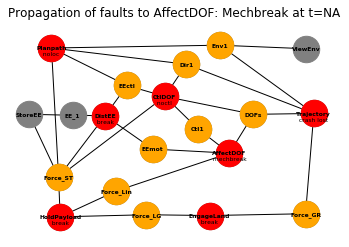

In [20]:
static_mdl = Drone_Static(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endresults, resgraph, mdlhist = fs.propagate.one_fault(static_mdl,'AffectDOF', 'mechbreak', gtype='bipartite')
fig, ax = rd.graph.show(resgraph, pos = bipartite_pos, faultscen='AffectDOF: Mechbreak', time='NA', scale=1, gtype='bipartite', retfig=True)
fig.savefig('static_propagation.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0)

### Dynamic Model

In the dynamic model, we add time ranges and dynamic behaviors to generate:

- Behavior-over-time graphs

- Dynamic/phase-based FMEAs

This model is located in `drone_mdl_dynamic.py`.

In [28]:
from drone_mdl_dynamic import Drone as Drone_Dynamic

Here we can see how the system operates over time in the nominal case:

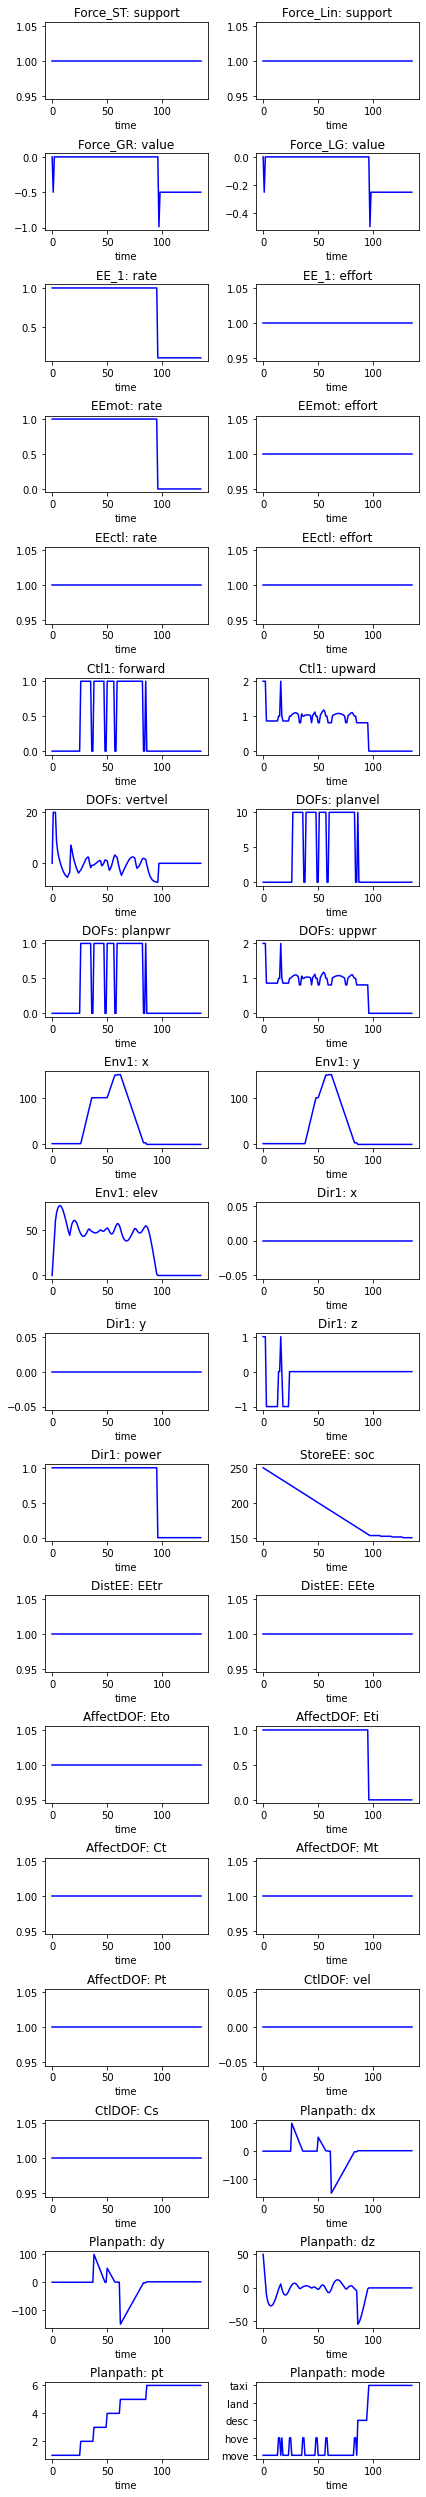

In [22]:
# Note: because of the complicated functions, the model must be re-instantiated for each function in order to work in this case
dynamic_mdl = Drone_Dynamic(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endresults, resgraph, mdlhist = fs.propagate.nominal(dynamic_mdl)
rd.plot.mdlhistvals(mdlhist)

As shown below, in the case of the break in the AffectDOF function, the system crashes:

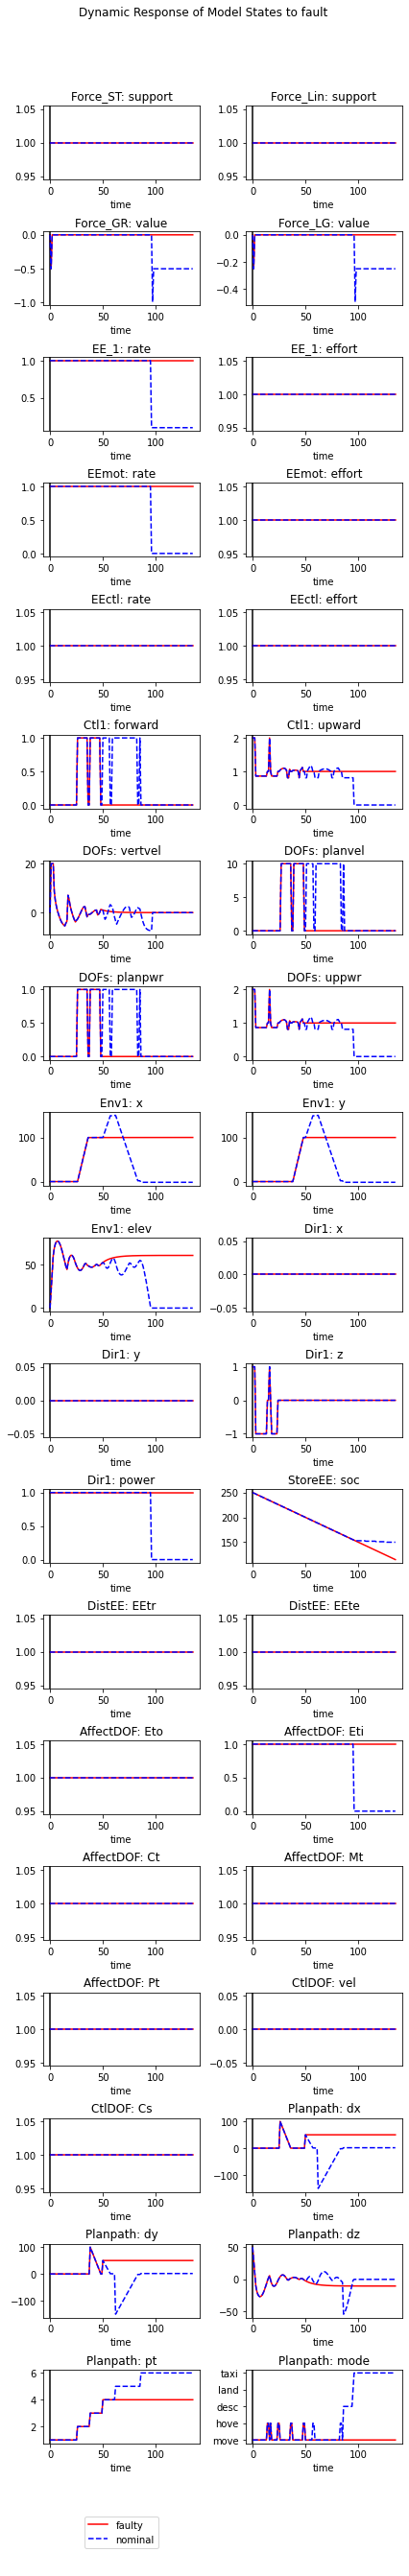

In [23]:
dynamic_mdl = Drone_Dynamic(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
endresults, resgraph, mdlhist = fs.propagate.one_fault(dynamic_mdl,'AffectDOF', 'mechbreak', time=50)

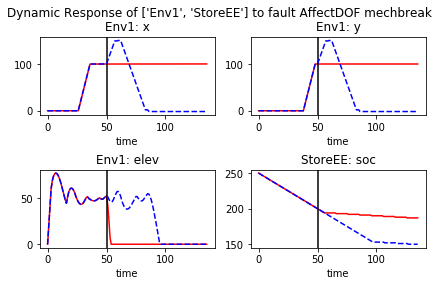

In [24]:
fig= rd.plot.mdlhistvals(mdlhist,'AffectDOF mechbreak', time=50, fxnflowvals={'Env1':['x','y','elev'], 'StoreEE':['soc']}, legend=False, returnfig=True)
fig.savefig("fault_behavior.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

Finally, we can see how the cost function of this scenario changes over time. As shown, when the fault is injected early, it has a lower cost because it crashes at the landing pad and not in a dangerous area. When it is injected at the end, the cost is minimal because the drone has already landed.

In [25]:
mdl_quad_comp = Drone_Dynamic(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos})
quad_comp_app = SampleApproach(mdl_quad_comp, faults=[('AffectDOF', 'mechbreak')],defaultsamp={'samp':'evenspacing','numpts':5})
quad_comp_endclasses, quad_comp_mdlhists = fs.propagate.approach(mdl_quad_comp, quad_comp_app, staged=False)

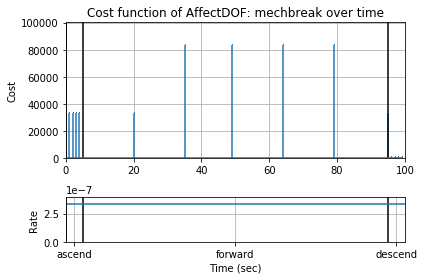

In [27]:
rd.plot.samplecost(quad_comp_app, quad_comp_endclasses, ('AffectDOF', 'mechbreak'))
fig = plt.gcf()
fig.savefig("cost_over_time.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

### Hierarchical Model

In the hierarchical model, we can use the simulation to compare system architectures. First by seeing how faults effect the behaviors in each architechture, then by seing how it affects the overall system resilience. 

This model is located in `drone_mdl_hierarchical.py`.

In [28]:
from drone_mdl_hierarchical import Drone as Drone_Hierarchical

First, we can model how the quadrotor architecture behaves under faults--in this case, identically to the non-hierarchical model:

In [38]:
hierarchical_model = Drone_Hierarchical(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'quad'})
endresults, resgraph, mdlhist = fs.propagate.one_fault(hierarchical_model,'AffectDOF', 'RFmechbreak', time=50)

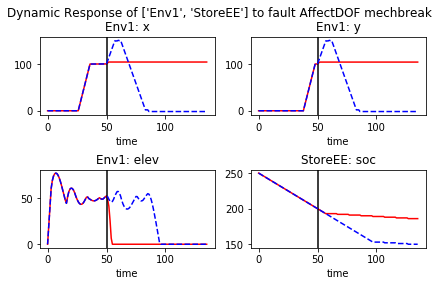

In [39]:
rd.plot.mdlhistvals(mdlhist,'AffectDOF mechbreak', time=50, fxnflowvals={'Env1':['x','y','elev'], 'StoreEE':['soc']}, legend=False)

Then we can see how the octorotor architecture performs in the same case:

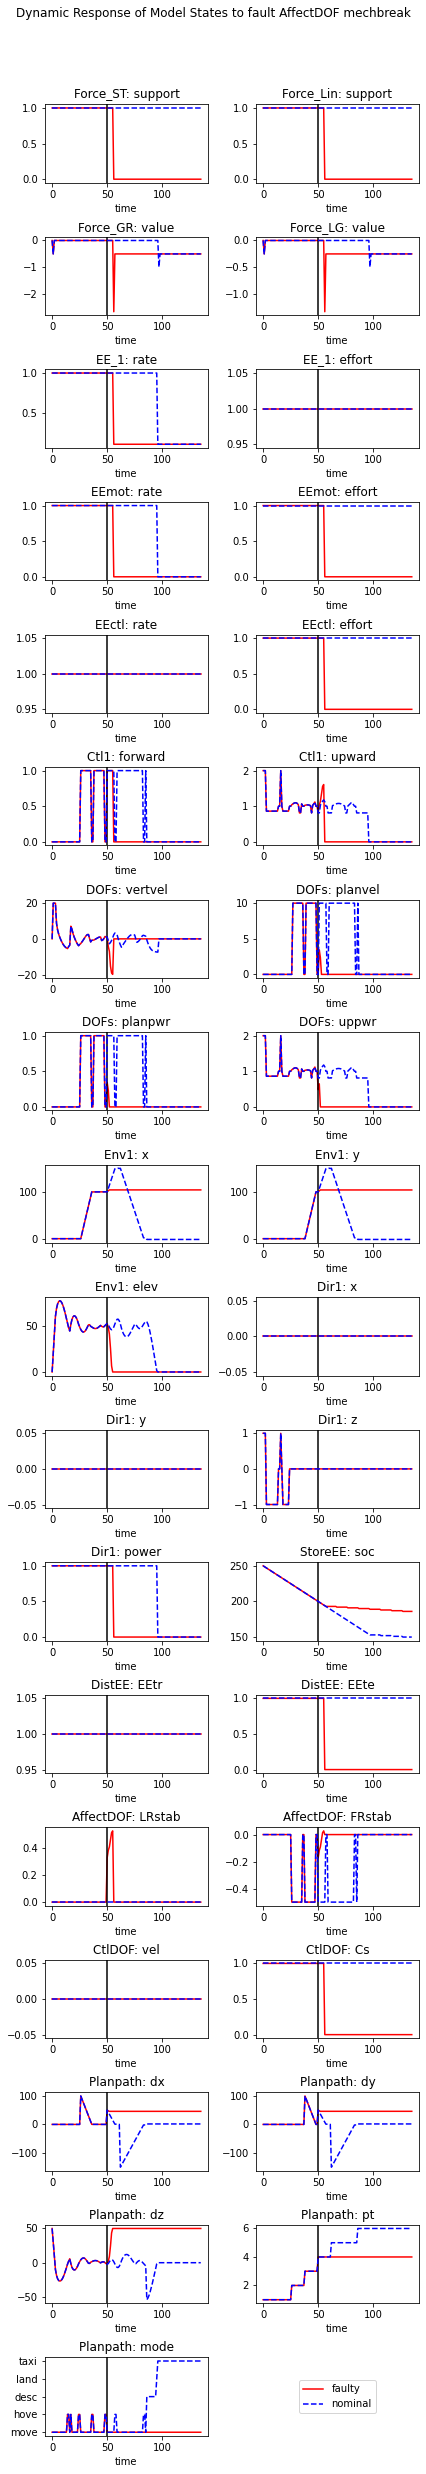

In [40]:
hierarchical_model = Drone_Hierarchical(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'oct'})
endresults, resgraph, mdlhist = fs.propagate.one_fault(hierarchical_model,'AffectDOF', 'RFmechbreak', time=50)

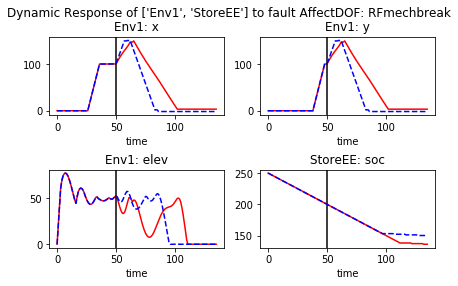

In [41]:
fig= rd.plot.mdlhistvals(mdlhist,'AffectDOF: RFmechbreak', time=50, fxnflowvals={'Env1':['x','y','elev'], 'StoreEE':['soc']}, legend=False, returnfig=True)
fig.savefig("red_fault_behavior.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

As shown, the octorotor architecture enables the quadrotor to recover from the fault and land.

In [46]:
#mdl_quad = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'quad'})
#app_quad = SampleApproach(mdl_quad)

In [47]:
#endclasses_quad, mdlhists_quad = fs.propagate.approach(mdl_quad, app_quad)

In [48]:
#quad_tab = rd.tabulate.simplefmea(endclasses_quad)
#quad_tab.sort_values('expected cost', ascending=False)[:400]

In [49]:
mdl_quad = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'quad'})
mdl_quad.fxns['AffectDOF'].faultmodes
quad_faults = [('AffectDOF', fault) for fault in list(mdl_quad.fxns['AffectDOF'].faultmodes.keys())]

In [50]:
quad_app = SampleApproach(mdl_quad, faults=quad_faults)
quad_endclasses, quad_mdlhists = fs.propagate.approach(mdl_quad, quad_app, staged=True)

In [51]:
quad_tab = rd.tabulate.simplefmea(quad_endclasses)
quad_tab.sort_values('expected cost', ascending=False)

,rate,cost,expected cost
"AffectDOF LFctlbreak, t=49.0",1.666667e-07,86800.0,1446.666667
"AffectDOF RFctlbreak, t=49.0",1.666667e-07,86800.0,1446.666667
"AffectDOF RRctlbreak, t=49.0",1.666667e-07,86800.0,1446.666667
"AffectDOF LRctlbreak, t=49.0",1.666667e-07,86800.0,1446.666667
"AffectDOF LRctldn, t=49.0",1.666667e-07,86300.0,1438.333333
...,...,...,...
"AffectDOF RRpropstuck, t=97.0",1.388889e-09,200.0,0.027778
"AffectDOF LRpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF RFpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LFpropwarp, t=97.0",6.944444e-10,200.0,0.013889


In [52]:
quad_res = sum(quad_tab['expected cost'])
quad_res

31220.157407407427

In [53]:
mdl_oct = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'oct'})
mdl_oct.fxns['AffectDOF'].faultmodes
oct_faults = [('AffectDOF', fault) for fault in list(mdl_oct.fxns['AffectDOF'].faultmodes.keys())]

In [54]:
mdl_oct = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'oct'})

In [55]:
oct_app = SampleApproach(mdl_oct, faults=oct_faults)
oct_endclasses, oct_mdlhists = fs.propagate.approach(mdl_oct, oct_app)

In [56]:
oct_tab = rd.tabulate.simplefmea(oct_endclasses)
oct_tab.sort_values('expected cost', ascending=False)

,rate,cost,expected cost
"AffectDOF RF2ctlup, t=49.0",1.666667e-07,89100.0,1485.000000
"AffectDOF RFctlup, t=49.0",1.666667e-07,89100.0,1485.000000
"AffectDOF LF2ctlup, t=49.0",1.666667e-07,89100.0,1485.000000
"AffectDOF LFctlup, t=49.0",1.666667e-07,89100.0,1485.000000
"AffectDOF RR2short, t=49.0",8.333333e-08,91800.0,765.000000
...,...,...,...
"AffectDOF RFpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LFpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LF2propwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LR2propwarp, t=97.0",6.944444e-10,200.0,0.013889


In [57]:
oct_res = sum(oct_tab['expected cost'])
oct_res

21588.83333333336

In [58]:
oct_tab.sort_values('expected cost', ascending=False)[100:]

,rate,cost,expected cost
"AffectDOF LRctlbreak, t=97.0",9.259259e-09,1000.0,0.925926
"AffectDOF RFctlbreak, t=2.0",9.259259e-09,1000.0,0.925926
"AffectDOF RR2ctlbreak, t=97.0",9.259259e-09,1000.0,0.925926
"AffectDOF LFctlbreak, t=97.0",9.259259e-09,1000.0,0.925926
"AffectDOF LF2propbreak, t=49.0",3.750000e-08,200.0,0.750000
...,...,...,...
"AffectDOF RFpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LFpropwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LF2propwarp, t=97.0",6.944444e-10,200.0,0.013889
"AffectDOF LR2propwarp, t=97.0",6.944444e-10,200.0,0.013889


In [59]:
rd.tabulate.summfmea(quad_endclasses,quad_app).sort_values('expected cost', ascending=False)

rate          cost  expected cost
AffectDOF RFctlbreak      1.851852e-07  41533.333333    1481.666667
          RRctlbreak      1.851852e-07  41533.333333    1481.666667
          LFctlbreak      1.851852e-07  41533.333333    1481.666667
          LRctlbreak      1.851852e-07  41533.333333    1481.666667
          RRctlup         1.851852e-07  41033.333333    1472.407407
          LRctlup         1.851852e-07  41033.333333    1472.407407
          RFctlup         1.851852e-07  41033.333333    1472.407407
          LFctlup         1.851852e-07  41033.333333    1472.407407
          RRctldn         1.851852e-07  29433.333333    1440.185185
          LRctldn         1.851852e-07  29433.333333    1440.185185
          RFctldn         1.851852e-07  29100.000000    1439.259259
          LFctldn         1.851852e-07  29100.000000    1439.259259
          RRshort         9.259259e-08  44400.000000     762.129630
          RFshort         9.259259e-08  44400.000000     762.129630
          LFshort         9.259259e-08  44400.000000     762.129630
          LRshort         9.259259e-08  44400.000000     762.129630
          LRopenc         9.259259e-08  40733.333333     733.425926
          LFopenc         9.259259e-08  40733.333333     733.425926
          RRopenc         9.259259e-08  40733.333333     733.425926
          RFopenc         9.259259e-08  40733.333333     733.425926
          LFmechbreak     9.259259e-08  40700.000000     731.805556
          LRmechbreak     9.259259e-08  40700.000000     731.805556
          RFmechbreak     9.259259e-08  40700.000000     731.805556
          RRmechbreak     9.259259e-08  40700.000000     731.805556
          RFmechfriction  6.597222e-08  43400.000000     539.548611
          RRmechfriction  6.597222e-08  43400.000000     539.548611
          LFmechfriction  6.597222e-08  43400.000000     539.548611
          LRmechfriction  6.597222e-08  43400.000000     539.548611
          LFpropbreak     3.958333e-08  43000.000000     321.791667
          LRpropbreak     3.958333e-08  43000.000000     321.791667
          RFpropbreak     3.958333e-08  43000.000000     321.791667
          RRpropbreak     3.958333e-08  43000.000000     321.791667
          LFpropstuck     2.638889e-08  43100.000000     215.027778
          LRpropstuck     2.638889e-08  43100.000000     215.027778
          RFpropstuck     2.638889e-08  43100.000000     215.027778
          RRpropstuck     2.638889e-08  43100.000000     215.027778
          LFpropwarp      1.319444e-08  43100.000000     107.513889
          LRpropwarp      1.319444e-08  43100.000000     107.513889
          RFpropwarp      1.319444e-08  43100.000000     107.513889
          RRpropwarp      1.319444e-08  43100.000000     107.513889

In [60]:
rd.tabulate.summfmea(oct_endclasses,oct_app).sort_values('expected cost', ascending=False)[:40]

rate          cost  expected cost
AffectDOF RFctlup       1.851852e-07  42900.000000    1521.666667
          RF2ctlup      1.851852e-07  42900.000000    1521.666667
          LF2ctlup      1.851852e-07  42900.000000    1521.666667
          LFctlup       1.851852e-07  42900.000000    1521.666667
          RFshort       9.259259e-08  46266.666667     786.759259
          RRshort       9.259259e-08  46266.666667     786.759259
          RF2short      9.259259e-08  46266.666667     786.759259
          LRshort       9.259259e-08  46266.666667     786.759259
          LF2short      9.259259e-08  46266.666667     786.759259
          LR2short      9.259259e-08  46266.666667     786.759259
          LFshort       9.259259e-08  46266.666667     786.759259
          RR2short      9.259259e-08  46266.666667     786.759259
          LR2ctlup      1.851852e-07  30033.333333     698.888889
          RR2ctlup      1.851852e-07  30033.333333     698.888889
          LRctlup       1.851852e-07  30033.333333     698.888889
          RRctlup       1.851852e-07  30033.333333     698.888889
          RR2ctlbreak   1.851852e-07  14200.000000     662.777778
          RRctlbreak    1.851852e-07  14200.000000     662.777778
          LR2ctlbreak   1.851852e-07  14200.000000     662.777778
          LRctlbreak    1.851852e-07  14200.000000     662.777778
          RRopenc       9.259259e-08  13400.000000     323.981481
          LR2openc      9.259259e-08  13400.000000     323.981481
          LRopenc       9.259259e-08  13400.000000     323.981481
          RR2openc      9.259259e-08  13400.000000     323.981481
          RRmechbreak   9.259259e-08  13533.333333     322.592593
          LRmechbreak   9.259259e-08  13533.333333     322.592593
          RR2mechbreak  9.259259e-08  13533.333333     322.592593
          LR2mechbreak  9.259259e-08  13533.333333     322.592593
          LR2propbreak  3.958333e-08  19400.000000     144.791667
          RRpropbreak   3.958333e-08  19400.000000     144.791667
          LRpropbreak   3.958333e-08  19400.000000     144.791667
          RR2propbreak  3.958333e-08  19400.000000     144.791667
          LRpropstuck   2.638889e-08  19500.000000      97.027778
          RRpropstuck   2.638889e-08  19500.000000      97.027778
          LR2propstuck  2.638889e-08  19500.000000      97.027778
          RR2propstuck  2.638889e-08  19500.000000      97.027778
          LFctlbreak    1.851852e-07   1000.000000      18.518519
          RF2ctlbreak   1.851852e-07   1000.000000      18.518519
          RFctlbreak    1.851852e-07   1000.000000      18.518519
          LF2ctlbreak   1.851852e-07   1000.000000      18.518519

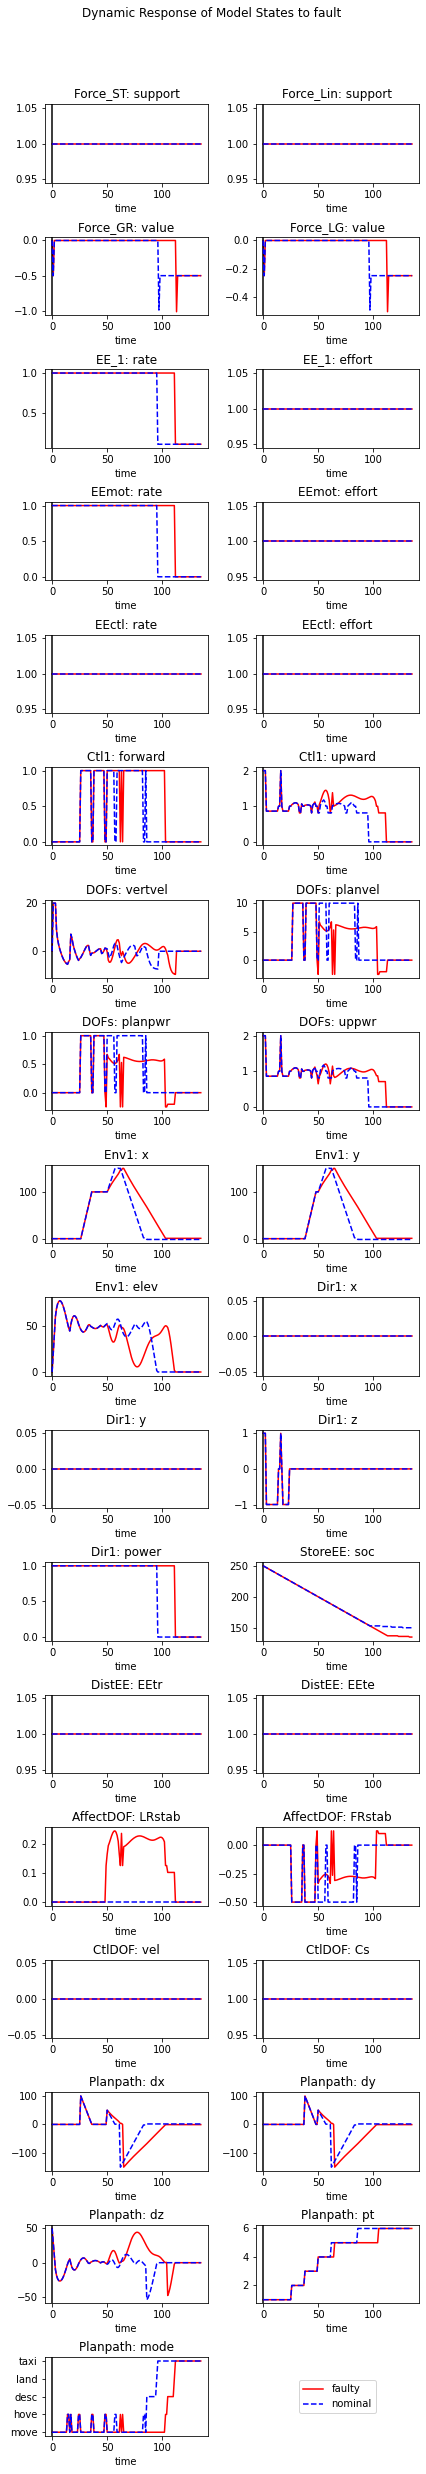

In [61]:
rd.plot.mdlhistvals({'nominal':oct_mdlhists['nominal'], 'faulty':oct_mdlhists['AffectDOF RFmechbreak, t=49.0']})

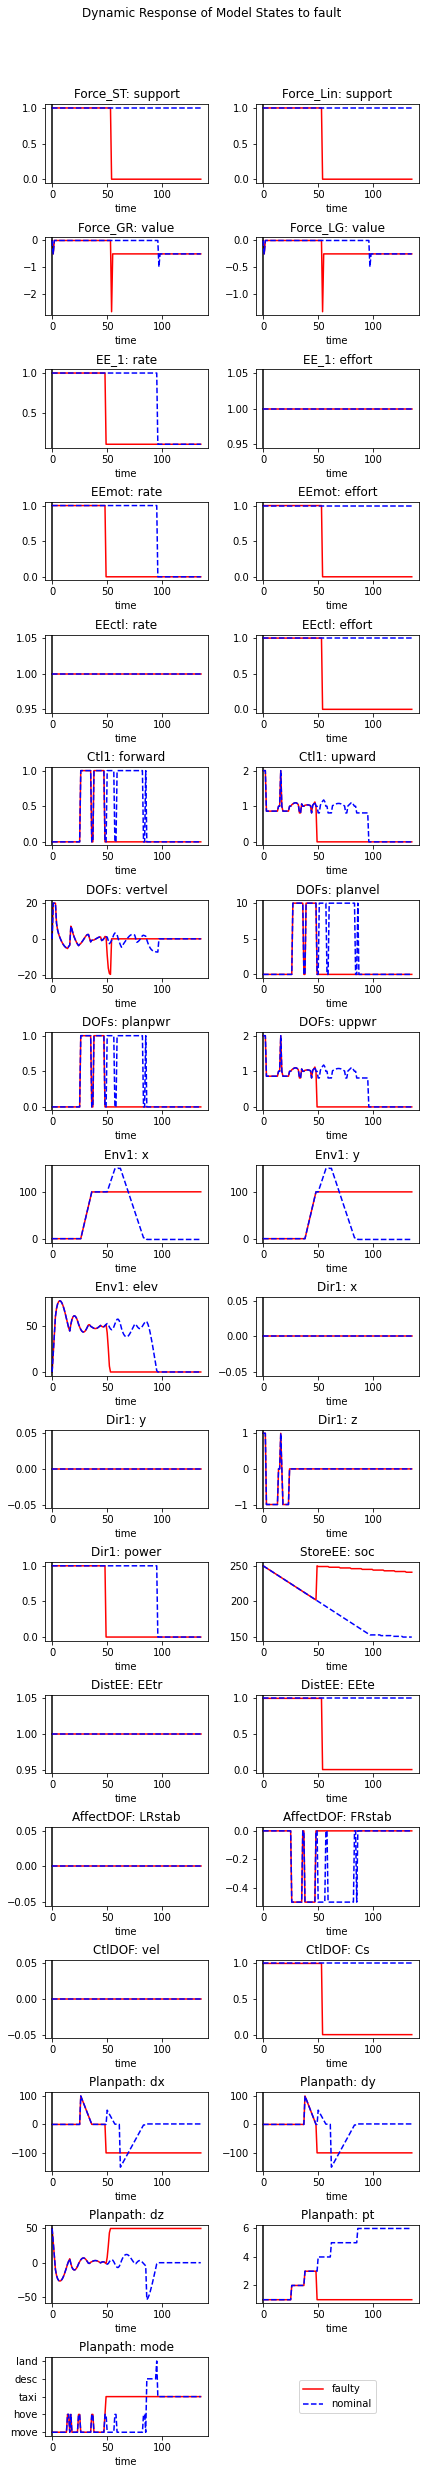

In [62]:
rd.plot.mdlhistvals({'nominal':quad_mdlhists['nominal'], 'faulty':quad_mdlhists['AffectDOF RFmechbreak, t=49.0']})

In [63]:
rd.tabulate.phasefmea(quad_app, quad_endclasses)

AttributeError: 'dict' object has no attribute 'scenids'

In [ ]:
rd.plot.samplecost(quad_app, quad_endclasses, ('AffectDOF', 'RFmechbreak'))

In [ ]:
rd.plot.samplecost(quad_app, quad_endclasses, ('AffectDOF', 'RFmechbreak'))

In [ ]:
mdl_oct_comp = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'oct'})
oct_comp_app = SampleApproach(mdl_oct_comp, faults=[('AffectDOF', 'RFmechbreak'),('AffectDOF', 'RF2mechbreak')],defaultsamp={'samp':'evenspacing','numpts':5})
oct_comp_endclasses, oct_comp_mdlhists = fs.propagate.approach(mdl_oct_comp, oct_comp_app, staged=False)

In [ ]:
rd.plot.samplecost(oct_comp_app, oct_comp_endclasses, ('AffectDOF', 'RFmechbreak'))

In [ ]:
rd.plot.mdlhistvals({'nominal':oct_comp_mdlhists['nominal'], 'faulty':oct_comp_mdlhists['AffectDOF RFmechbreak, t=35.0']} )

In [ ]:
mdl_oct_comp.fxns['AffectDOF'].components

In [ ]:
mdl_quad_comp = Drone(params={'graph_pos':graph_pos, 'bipartite_pos':bipartite_pos,'arch':'quad'})
quad_comp_app = SampleApproach(mdl_quad_comp, faults=[('AffectDOF', 'RFmechbreak')],defaultsamp={'samp':'evenspacing','numpts':5})
quad_comp_endclasses, quad_comp_mdlhists = fs.propagate.approach(mdl_quad_comp, quad_comp_app, staged=False)


In [ ]:
rd.plot.mdlhistvals({'nominal':quad_comp_mdlhists['nominal'], 'faulty':quad_comp_mdlhists['AffectDOF RFmechbreak, t=35.0']} )

In [ ]:
rd.plot.mdlhistvals({'nominal':quad_comp_mdlhists['nominal'], 'faulty':quad_comp_mdlhists['AffectDOF RFmechbreak, t=20.0']} )